This notebook loads the pickled dictionary with the presidents' raw and aggregated popularity, concatenates the raw popularity of each one, and saves all these data in a unique CSV file for sharing

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
all_presidents = pd.read_excel("../data/raw_popularity_presidents.xlsx", index_col=0, parse_dates=True)
all_presidents

,president,sondage,samplesize,method,approve_pr,disapprove_pr
1978-09-28,vge,Kantar,1040,face to face,60.0,33.0
1978-10-17,vge,Ifop,949,phone,52.0,35.0
1978-10-28,vge,Kantar,964,face to face,59.0,34.0
1978-11-19,vge,Ifop,1069,phone,53.0,37.0
1978-11-24,vge,Kantar,928,face to face,62.0,33.0
...,...,...,...,...,...,...
2020-07-10,macron,Ifop,1018,internet,38.0,62.0
2020-07-16,macron,BVA,1000,internet,39.0,61.0
2020-07-16,macron,Ifop,974,internet,37.0,63.0
2020-07-22,macron,Harris,960,internet,50.0,50.0


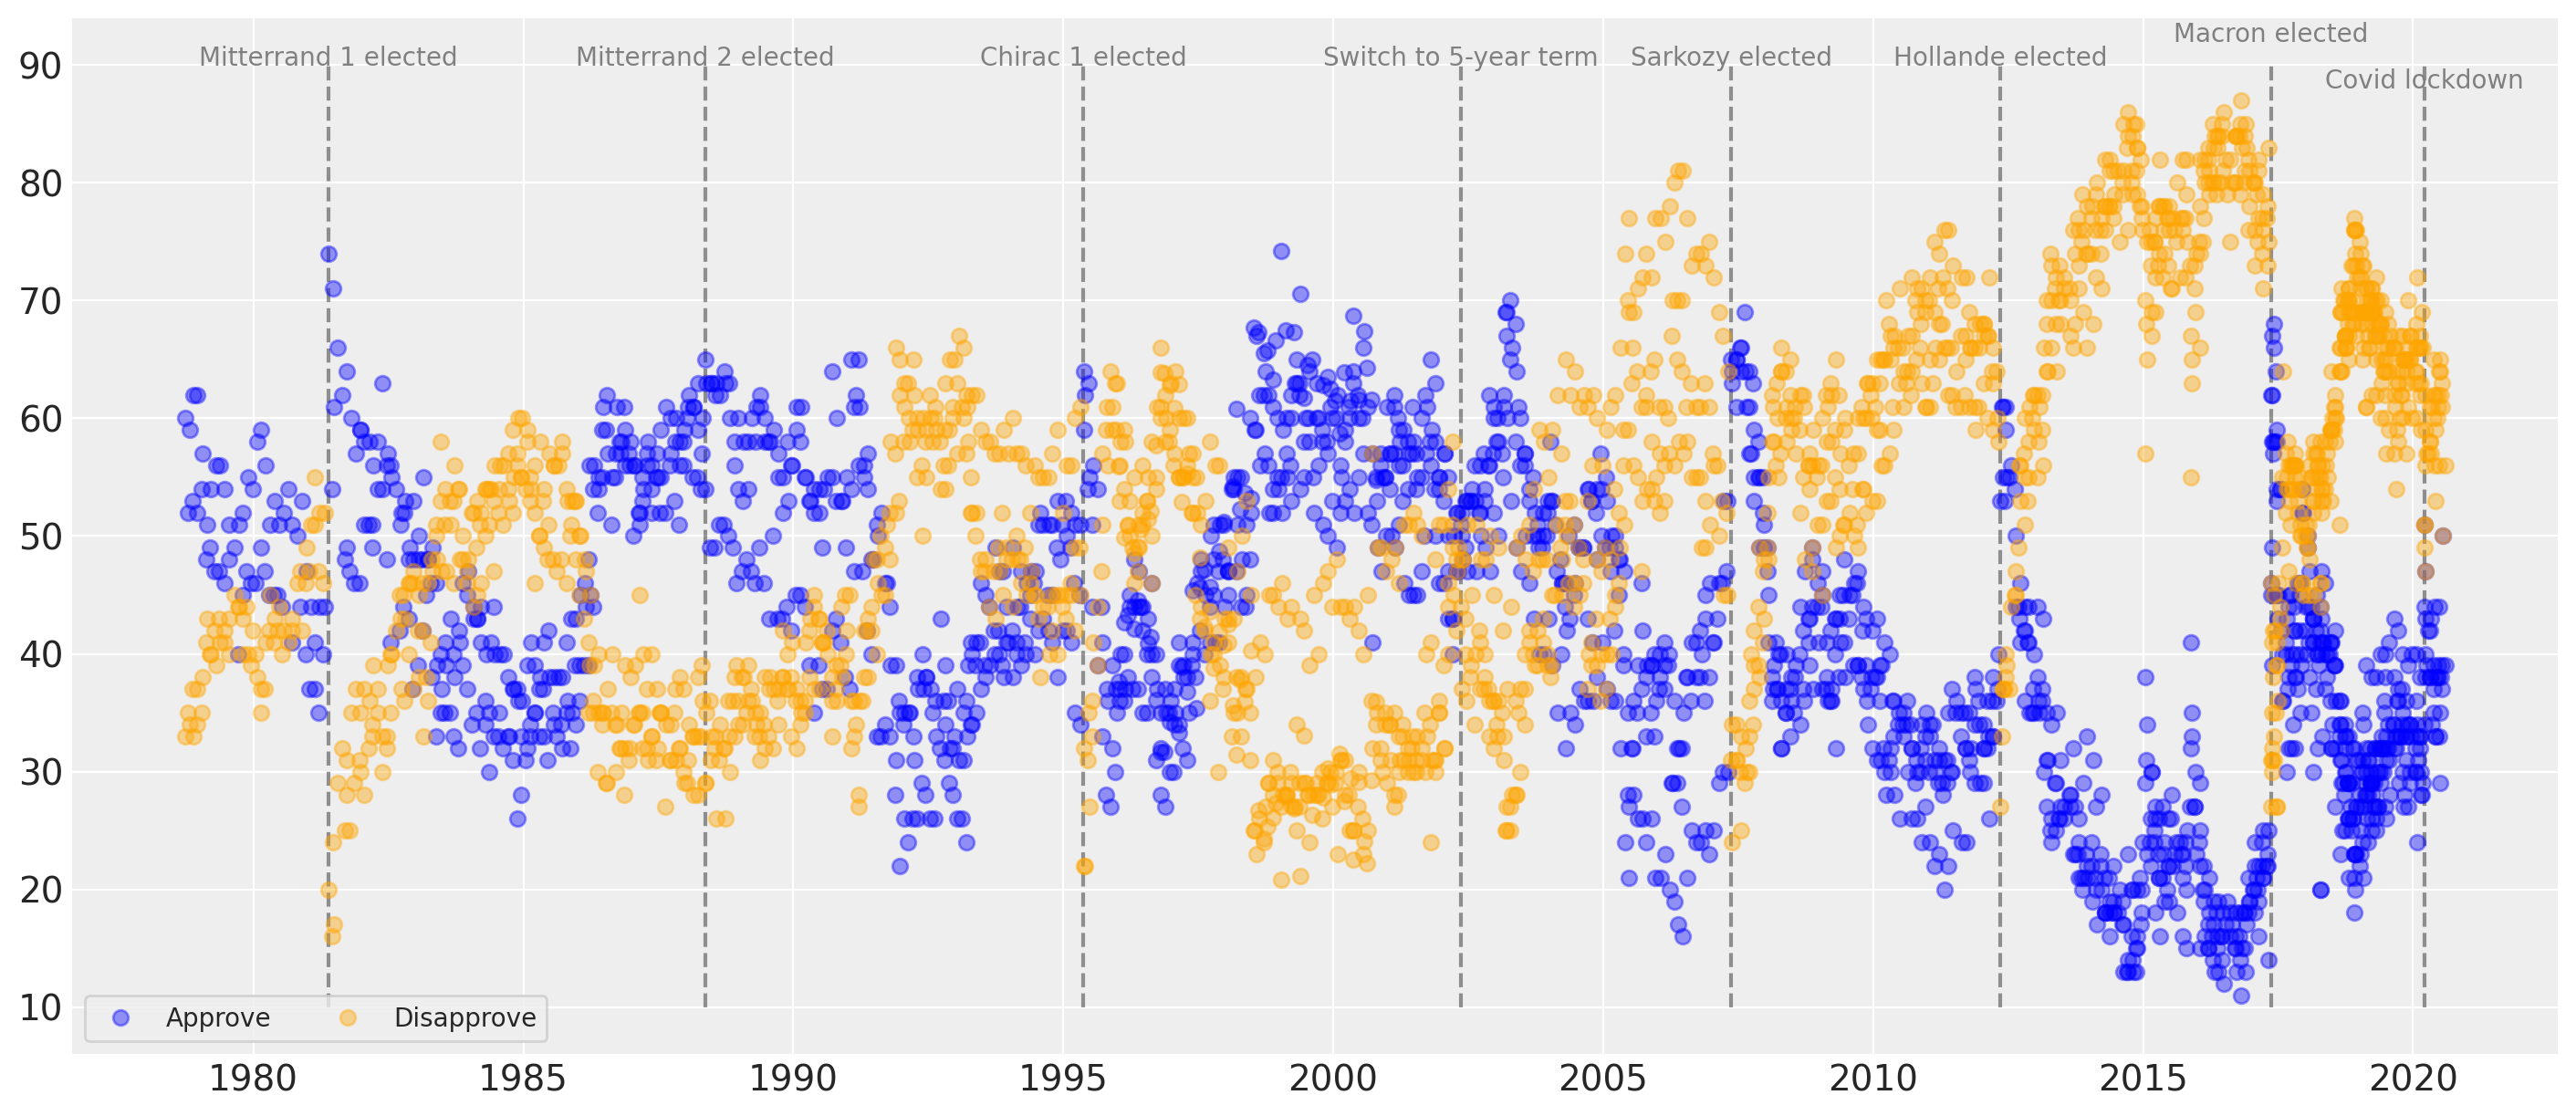

In [35]:
_, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(all_presidents.index, all_presidents.approve_pr, "ob", label="Approve", alpha=0.4)
ax.plot(all_presidents.index, all_presidents.disapprove_pr, "o", color="orange", label="Disapprove", alpha=0.4)

ax.vlines(pd.to_datetime("1981-05-25"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1981-05-25"), 90, "Mitterrand 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1988-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1988-05-16"), 90, "Mitterrand 2 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1995-05-18"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1995-05-18"), 90, "Chirac 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2002-05-14"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2002-05-14"), 90, "Switch to 5-year term", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2007-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2007-05-16"), 90, "Sarkozy elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2012-05-11"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2012-05-11"), 90, "Hollande elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2017-05-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2017-05-17"), 92, "Macron elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2020-03-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2020-03-17"), 88, "Covid lockdown", fontsize=10, color="grey", horizontalalignment="center")

plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);